# TP3 - Modèles probabilistes génératifs pour le Machine Learning

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.datasets import mnist

from sklearn.metrics import mean_squared_error

import torch.nn.functional as F
import torchvision.transforms.functional as Fu
from torchvision.utils import make_grid

Chargement du jeu de données MNIST et conversion des données en binaire (0,1)

In [96]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()
x_train[x_train > 0.5 ] = 1
x_test[x_test > 0.5 ] = 1

Affichage de quelques données du dataset

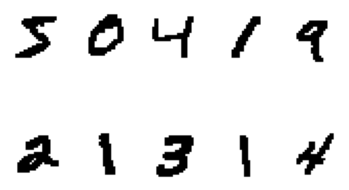

In [97]:
fig = plt.Figure()

for i in range(10):
    fig1 = plt.subplot(2,5,i+1)
    fig1.imshow(x_train[i], cmap="gray_r")
    fig1.axis("off")

Séparation des données en training et test set en fonction de leur classification

In [ ]:
data = {}
for i in range(10):
    data[str(i)]=[x_train[y_train==i][:1000],x_test[y_test==i][:1000]]

# Partie Théorique

## 1) Structures des RBM

On va construire une Machine de Boltzmann Restreinte (RBM) pour générer une représentation améliorée des chiffres.
Les RBM comportent des unités cachées et visibles et consiste en une matrice de poids $W$ de taille $m × n$.

Chaque élément de poids $w_{i,j})$ de la matrice est associé à la connexion entre l'unité visible (d'entrée) $x_{i}$ et l'unité cachée $h_{j}$. En outre, il existe des poids de biais (décalages) $a_{i}$ pour $x_{i}$ et $b_{j}$ pour $h_{j}$, cela est illustré dans le figure suivante : 

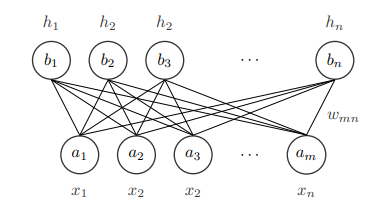

Compte tenu des poids et des biais, l'énergie d'une configuration (paire de vecteurs booléens) (x, h) est définie comme suit :  

$$E(x ,h) = -h^T W x -a^T x -b^T h = -\sum_{j}\sum_{k} (w_{j,k} h_j x_k) -\sum_{k} (a_k x_k) -\sum_{j} (b_j h_j)$$


La distribution de probabilité conjointe pour les vecteurs visibles et cachés est définie en termes de fonction d'énergie comme suit :  

$$p(x, h) = \frac{e^{-E(x, h)}}{Z_θ} = \frac{e^{h^T W x +a^T x +b^T h}}{Z_θ} = \frac{e^{(h^T W x} + e^{a^T x} + e^{b^T h}}{Z_θ} = \frac{\prod_{j}\prod_{k} (w_{j,k} h_j x_k) * \prod_{k} (a_k x_k) * \prod_{j} (b_j h_j)}{Z_θ}$$

où $Z_θ$ est une fonction de partition définie comme la somme de $e^{-E(x, h)}$ sur toutes les configurations possibles, qui peut être interprétée comme une constante de normalisation pour garantir que la somme des probabilités est égale à 1.  

La probabilité marginale d'un vecteur visible est la somme de $P(x, h)$ sur toutes les configurations possibles de la couche cachée :  

$$P(x)=\frac{1}{Z_θ}\sum _{h} e^{-E(x, h)}$$
    ,

et vice versa. Comme la structure graphique sous-jacente du RBM est bipartite (ce qui signifie qu'il n'y a pas de connexions intra-couche), les activations des unités cachées sont mutuellement indépendantes des activations des unités visibles.  

Inversement, les activations des unités visibles sont mutuellement indépendantes des activations des unités cachées, c'est-à-dire que pour m unités visibles et n unités cachées, la probabilité conditionnelle d'une configuration des unités visibles x, compte tenu d'une configuration des unités cachées h, est la suivante : 

$$P(x|h) = \prod_{i=1}^{m} P(x_i|h)$$
    .

Inversement, la probabilité conditionnelle de h étant donné v est : 

$$P(h|x) = \prod_{j=1}^{n} P(h_j|x)$$.

Les probabilités d'activation individuelles sont données par

   $$P(h_{j}=1|x)=\sigma \left(b_{j}+\sum _{i=1}^{m}w_{i, j}x_{i}\right)$$ 
   $$P(x_i=1|h) = \sigma \left(a_i + \sum_{j=1}^n w_{i,j} h_j \right)$$

où σ désigne la sigmoïde logistique.

## 2) Entrainement des RBM

Les machines de Boltzmann restreintes sont entraînées pour maximiser le produit des probabilités attribuées à un certain ensemble d'entraînement $X$ (une matrice, dont chaque ligne est traitée comme un vecteur visible $x$),

$$\arg\max_W \prod_{x \in X} P(x)$$

L'algorithme le plus souvent utilisé pour entraîner les RBM, c'est-à-dire pour optimiser la matrice de poids $W$, est l'algorithme de divergence contrastive d'Hinton. L'algorithme effectue un échantillonnage de Gibbs et est utilisé à l'intérieur d'une procédure de descente de gradient pour calculer la mise à jour des poids.

La procédure de base de divergence contrastive en une seule étape pour un seul échantillon peut être résumée comme suit :

1. Prenez un échantillon de formation x, calculez les probabilités des unités cachées et échantillonnez un vecteur d'activation caché h à partir de cette distribution de probabilité.

2. Calculer le produit externe de v et de h et l'appeler le gradient positif.

3. À partir de h, échantillonnez une reconstruction x' des unités visibles, puis rééchantillonnez les activations cachées h' à partir de celle-ci. (étape d'échantillonnage de Gibbs)

4. Calculer le produit externe de x' et h' et l'appeler le gradient négatif.

5. La mise à jour de la matrice de poids $W$ est le gradient positif moins le gradient négatif, multiplié par un certain taux d'apprentissage : $\Delta W=\epsilon (vh^{\mathsf {T}}-v'h'^{\mathsf {T}})$.
    
6. Mettre à jour les biais a et b de manière analogue : $\Delta a=\epsilon (v-v')$, $\Delta b=\epsilon (h-h')$.

Finalement, on cherche a atteindre un minimum de la fonction de perte par des mise a jour successives, comme présenté dans la figure ci-dessous :

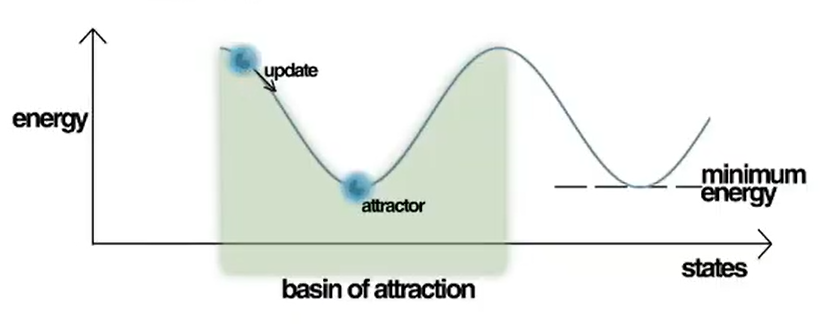

# Partie pratique 

## 1) Implémentation du RBM

In [115]:
class RBM():
    def __init__(self, visible_dim, hidden_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.w = torch.randn(hidden_dim,visible_dim)*0.001
        self.x_bias = torch.zeros(visible_dim)
        self.x_bias.requires_grad = True
        self.h_bias = torch.zeros(hidden_dim)

    #caché_sachant_visible
    def forward_propagation(self, x):
        #h(x)=p(h/x)=sigmoid(b+w*x)
        return torch.sigmoid(F.linear(x, self.w, self.h_bias))
    
    #visible_sachant_caché
    def backward_propagation(self, h):
        #x(h)=p(x/h)=sigmoid(a+h*w.T)
        return torch.sigmoid(F.linear(h, self.w.T, self.x_bias))
         
    def sample(self, nb_sample, K):
        x = torch.bernoulli(torch.empty(nb_sample, self.visible_dim).uniform_(0,1))
        for i in range(1,K):
            h = self.forward_propagation(x)
            x = self.backward_propagation(h)
        return x
    
    def energie(self, x):
        xbias = x @ self.x_bias
        hidden = F.linear(x, self.w, self.h_bias).exp().add(1).log().sum(1)
        return (-hidden-xbias)
   
    def loss(self, x, x_tilde):
        #loss = self.energie(x).mean() - self.energie(x_tilde).mean()
        loss = torch.nn.functional.mse_loss(x, self.backward_propagation(self.forward_propagation(x)))
        return loss

    def train(self, target_sample, batch_size, lr, epochs, verbose=False):
        dataset = torch.utils.data.TensorDataset(target_sample)
        optim = torch.optim.Adam([self.x_bias, self.h_bias, self.w], lr)
        loss_list = []
        for t in tqdm(range(epochs), total = epochs,desc ="Training RBM "):
            loss_ = []
            dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
            for batch in dataloader:
                x = batch[0]
                x_tilde = self.sample(batch_size,5)
                loss = self.loss(x, x_tilde)
                loss_.append(loss.data)
                optim.zero_grad()  #remet a zéro les valeurs du gradient
                loss.backward()  #calcul des valeurs du gradient de la loss
                optim.step()  #met a jour les paramètres de l'optimiseur avec les valeurs de gardient calcuées àa l'étape précédante
                loss_list.append(loss.data)
        print("Training finished at epoch {} with a loss of : {}".format(t+1, np.mean(loss_)))
        return loss_list

Fonction pour entrainer un RBM, grace aux données et aux paramètres de l'entrainement.  
Elle renvoie les résultats de l'entrainement, c'est-à-dire la liste des loss et le modèle entrainé

In [279]:
def train_RBM(train_set, batch_size, epochs, h_dim, lr):
    model = RBM(28*28,h_dim)
    train_set = torch.tensor(train_set.reshape(-1,28*28)).float()
    loss = model.train(train_set, batch_size, lr, epochs, verbose = True)
    return loss, model

Fonction pour transformer l'outpout du modèle en binaire

In [ ]:
def mask(img):
    img[img>=0.5]=1
    img[img<0.5]=0
    return img

Fonction pour générer une inférence avec un modèle déja entrainé.  
Elle renvoie l'image initiale et l'image obtenue

In [ ]:
def get_inference(model, data):
    img1 = torch.tensor(data[0])
    img2 = img1.reshape(-1,28*28).float()
    h = model.forward_propagation(img2)
    img2 = mask(model.backward_propagation(h))  
    img2 = mask(img2).reshape(28,28)
    return img1, img2

Fonction qui utilise torchvision pour afficher une liste d'images en lignes

In [222]:
def n_col(liste):
    if len(liste)<3:
        return len(liste)
    else:
        return 3

def draw_images(img_list):
    grid = make_grid(img_list)
    fig, axs = plt.subplots(ncols=n_col(img_list), nrows=int(len(img_list)/3)+1, squeeze=False, figsize=(8,8))
    for j, img in enumerate(grid):
        img = img.detach()
        img = Fu.to_pil_image(img)
        axs[j//3, j%3].imshow(np.asarray(img), cmap="gray_r")
        axs[j//3, j%3].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()  

Fonction qui affiche une liste de loss en ligne

In [226]:
def draw_loss(loss_list):
    fig, axs = plt.subplots(ncols=n_col(loss_list), nrows=int(len(loss_list)/3)+1, squeeze=False, figsize=(15,10))
    for j, loss in enumerate(loss_list):
        axs[j//3, j%3].plot(loss)

    plt.show() 

## 2) Quelques essais pour débuter avec les RBM

Premier entrainement d'un modèle

Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.76it/s]

Training finished at epoch 25 with a loss of : 0.13305243849754333


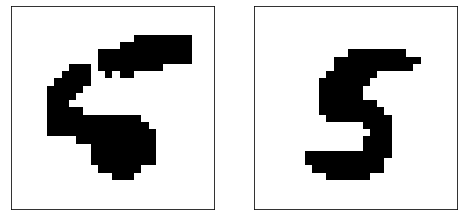

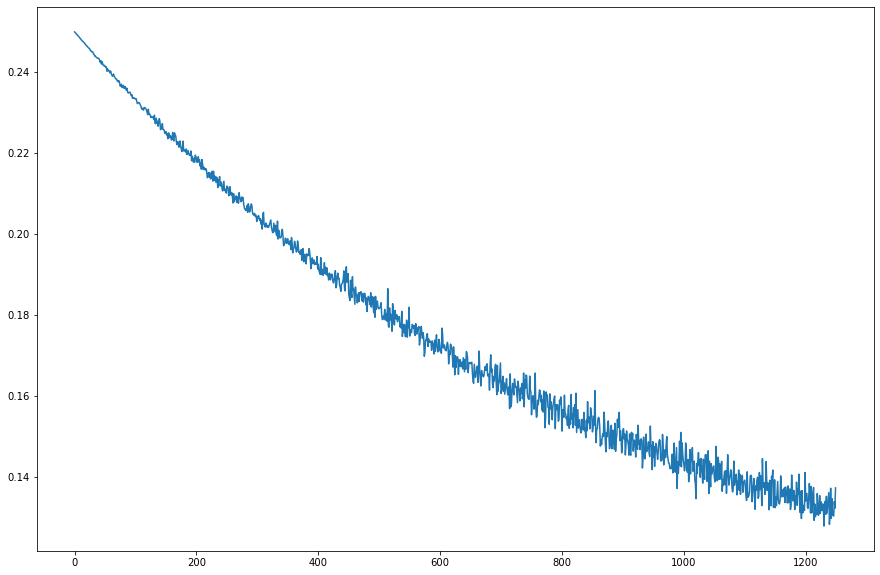

In [227]:
train_set,test_set = data["5"]    
loss, model = train_RBM(train_set, 20, 25, 500, 0.001)
img_initiale, img_transformée = get_inference(model, test_set)
draw_images([img_initiale,img_transformée])
draw_loss([loss])

Entrainement d'un modèle pour chaques classes du dataset MNIST.  
Donc de 10 modèles

In [230]:
loss_list=[]
img_list=[]
for i in range(10):
    train_set,test_set = data[str(i)]    
    loss, model = train_RBM(train_set, 20, 25, 500, 0.001)
    img_initiale, img_transformée = get_inference(model, test_set)
    img_list.append(img_transformée)
    loss_list.append(loss)

Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.55it/s]


Training finished at epoch 25 with a loss of : 0.1271822303533554


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.78it/s]


Training finished at epoch 25 with a loss of : 0.10074588656425476


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.58it/s]


Training finished at epoch 25 with a loss of : 0.13255321979522705


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.67it/s]


Training finished at epoch 25 with a loss of : 0.12708993256092072


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.77it/s]


Training finished at epoch 25 with a loss of : 0.12433303892612457


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.76it/s]


Training finished at epoch 25 with a loss of : 0.13308283686637878


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.78it/s]


Training finished at epoch 25 with a loss of : 0.1210261732339859


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.71it/s]


Training finished at epoch 25 with a loss of : 0.11838033050298691


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.80it/s]


Training finished at epoch 25 with a loss of : 0.12516169250011444


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.70it/s]

Training finished at epoch 25 with a loss of : 0.11893299967050552


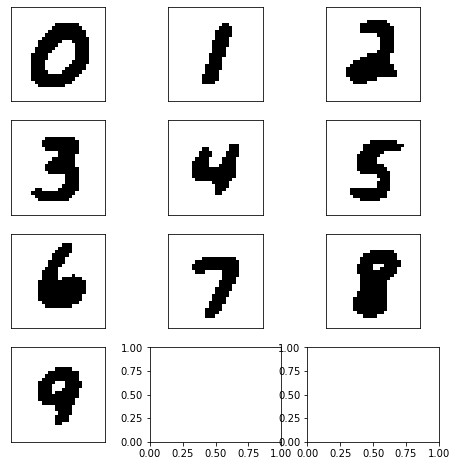

In [231]:
draw_images(img_list)

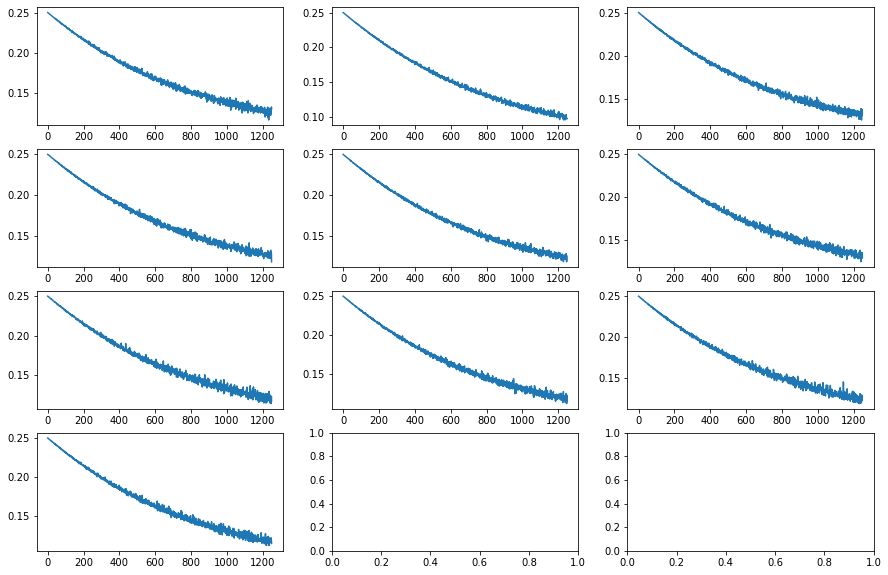

In [232]:
draw_loss(loss_list)

## 3) Variation "naïve" des paramètres d'entrainement

On voit que le nombre le plus complexe semble être le 8.  
Essaions donc de faire varier les paramètre d'entrainement sur ce nombre, pour observer comme le résultat évolue en fonction de ceux-ci.

In [280]:
train_set,test_set = data["8"]   

### 3.1. Nombre d'epochs

Commençons par faire varier le nombre d'epochs.  
Prenons les valeurs suivantes : 10, 25, 50, 100 et 150

In [281]:
loss_list=[]
img_list=[]
epochs_values = [10, 25, 50, 100, 150]
for epochs in epochs_values:
    loss, model = train_RBM(train_set, 20, epochs, 500, 0.001)
    _, img_transformée = get_inference(model, test_set)
    img_list.append(img_transformée)
    loss_list.append(loss)

Training RBM : 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.66it/s]


Training finished at epoch 10 with a loss of : 0.1799188107252121


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.66it/s]


Training finished at epoch 25 with a loss of : 0.12515372037887573


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.86it/s]


Training finished at epoch 50 with a loss of : 0.09607741236686707


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.02it/s]


Training finished at epoch 100 with a loss of : 0.08476974815130234


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 150/150 [00:29<00:00,  5.02it/s]

Training finished at epoch 150 with a loss of : 0.0828547477722168


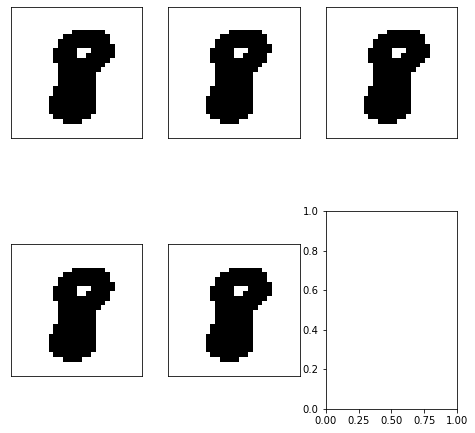

In [282]:
draw_images(img_list)

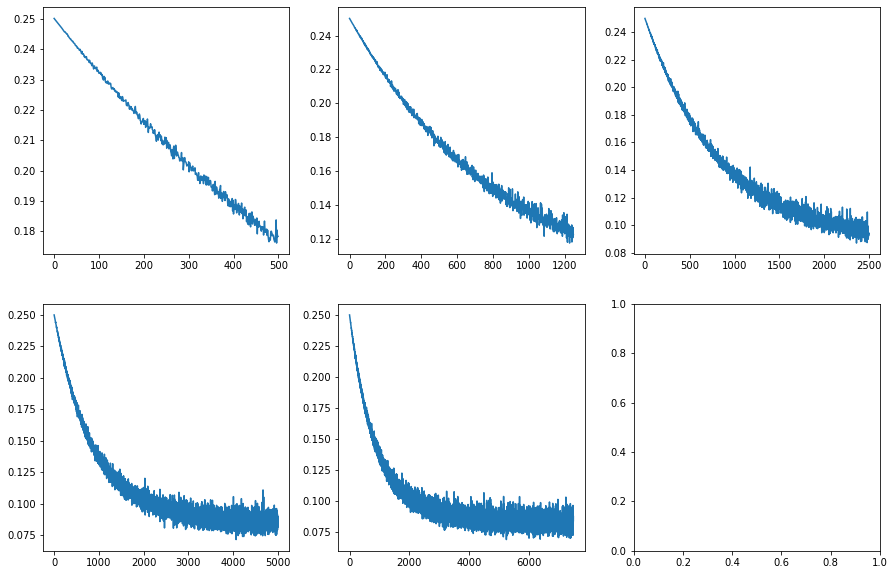

In [283]:
draw_loss(loss_list)

Ce paramètre représente le nombre de fois que l'on va fournir le jeu de données d'entrainement au réseau. Cela va lui permeètre d'améliorer ses poids globalement en se réentrainant sur les même données.  

Dans notre cas, on voit que les résultats obtenus avec 10 et 25 épochs ne sont pas suffisants pour permettre un entrainement complet du réseau, car la loss n'atteint pas son minimum dans ces cas là.  

Finalement, on obtient des résultats corrects pour 50, 100 et 150 épochs. Conservons donc un nombre de 100 epochs pour la suite

### 3.2. Taille du batch

Ensuite, faisons varier la taille du batch.  
Prenons les valeurs suivantes : 10, 20, 32, 64 et 128

In [284]:
loss_list=[]
img_list=[]
batch_size_values = [10, 20, 32, 64, 128]
for batch_size in batch_size_values:
    loss, model = train_RBM(train_set, batch_size, 100, 500, 0.001)
    _, img_transformée = get_inference(model, test_set)
    img_list.append(img_transformée)
    loss_list.append(loss)

Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


Training finished at epoch 100 with a loss of : 0.08241093903779984


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]


Training finished at epoch 100 with a loss of : 0.08477149158716202


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.81it/s]


Training finished at epoch 100 with a loss of : 0.09034140408039093


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.50it/s]


Training finished at epoch 100 with a loss of : 0.11195162683725357


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.82it/s]

Training finished at epoch 100 with a loss of : 0.1496008038520813


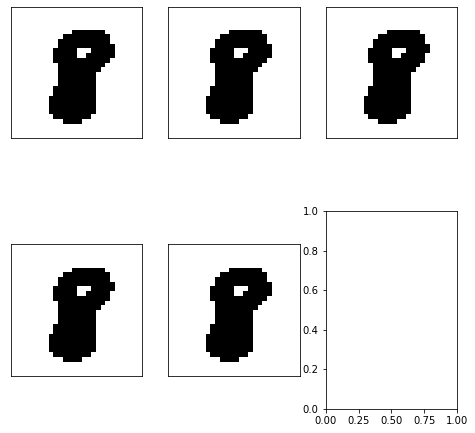

In [285]:
draw_images(img_list)

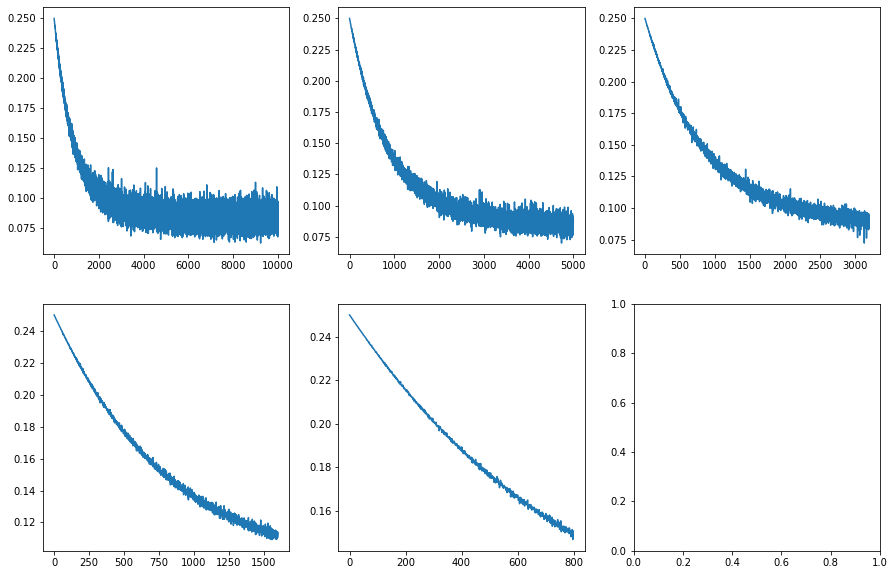

In [286]:
draw_loss(loss_list)

La taille du lot (batch size) représente le nombre de données qui sont fournis au réseau avant qu'il ne calcul la descente du gradient lui permettant d'améliorer ses poids.  

Si ce paramètre est trop faible, les données présentes dans le batch ne seront pas assez significatives du jeu de données d'entrainement pour permettre la calcul d'un gradient pertient.  
Si ce paramètre est trop élevé, le calcul du gradient sera pertient mais les poids ne seront pas assez mis a jour a long d'une epoch pour permettre un apprentissage efficace.  

Dans notre cas, on voit que les lot de taille 128 et 64 n'ont pas donné des entrainements aboutis. Contrairement aux valeurs 10, 20 et 32. On prendra pour la suite la valeur 20.

### 3.3. Taux d'apprentissage 

Ensuite, faisons varier le taux d'apprentissage.  
Prenons par exemple les valeurs suivantes : 1e-1, 1e-2, 1e-3, 1e-4 et 1e-5.

In [287]:
loss_list=[]
img_list=[]
lr_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_values:
    loss, model = train_RBM(train_set, 20, 100, 500, lr)
    _, img_transformée = get_inference(model, test_set)
    img_list.append(img_transformée)
    loss_list.append(loss)

Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.45it/s]


Training finished at epoch 100 with a loss of : 0.08268969506025314


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]


Training finished at epoch 100 with a loss of : 0.08232486993074417


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


Training finished at epoch 100 with a loss of : 0.08477013558149338


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


Training finished at epoch 100 with a loss of : 0.17578163743019104


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]

Training finished at epoch 100 with a loss of : 0.2409413903951645


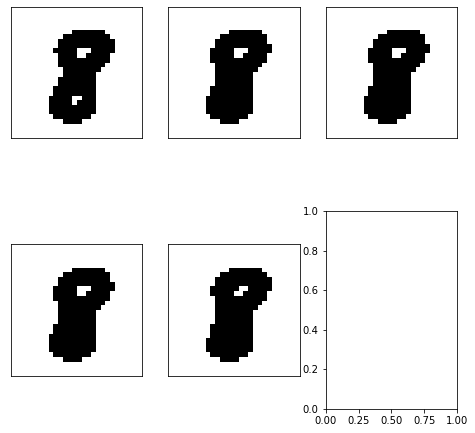

In [288]:
draw_images(img_list)

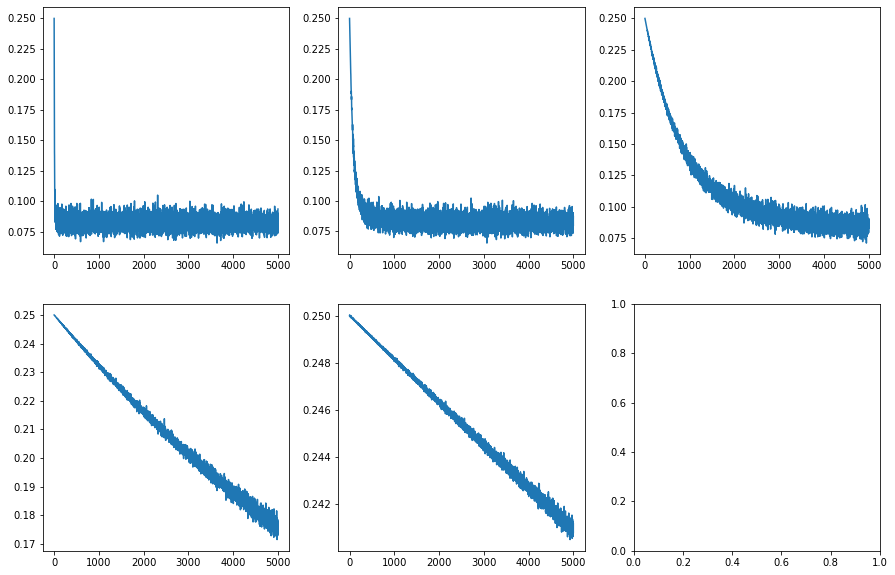

In [289]:
draw_loss(loss_list)

Le taux d'apprentissage représente la puissance de la mise a jour des poids du réseau à la suite du calcul du gradient.  

Plus celui-ci est élevé, la modification des poids sera importante a la fin du batch.
Plus celui-ci est faible, moins les poids évolueront à la fin de chaques batch.

Que les courbes de loss de 1e-5  et 1e-4 ne sont pas terminées, cela veut dire que l'entrainement a été arrété avec d'avoir été totalement réalisé.  

Et finalement, les résulats pour 1e-3, 1e-2 et 1e-1 semble bon, prenons donc 1e-2 pour la suite de nos experiences. 

### 3.4. Dimension du vecteur caché

Ensuite, faisons varier la dimension du vecteur caché.  
Prenons les paramètres suivants : 10, 100, 500, 1000 et 2000

In [290]:
loss_list=[]
img_list=[]
hidden_dim_values = [10, 100, 500, 1000, 2000]
for h_dim in hidden_dim_values:
    loss, model = train_RBM(train_set, 20, 100, h_dim, 1e-2)
    _, img_transformée = get_inference(model, test_set)
    img_list.append(img_transformée)
    loss_list.append(loss)

Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.19it/s]


Training finished at epoch 100 with a loss of : 0.08232185244560242


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


Training finished at epoch 100 with a loss of : 0.08232228457927704


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.82it/s]


Training finished at epoch 100 with a loss of : 0.08231843262910843


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.61it/s]


Training finished at epoch 100 with a loss of : 0.08230989426374435


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]

Training finished at epoch 100 with a loss of : 0.08229437470436096


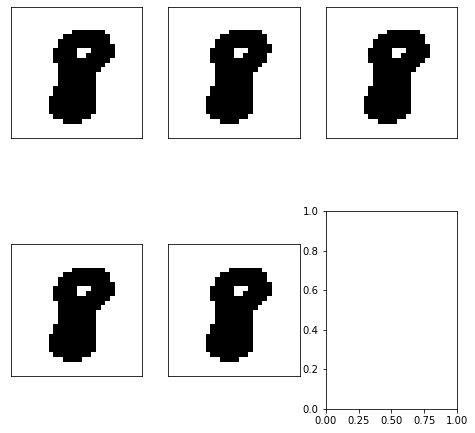

In [291]:
draw_images(img_list)

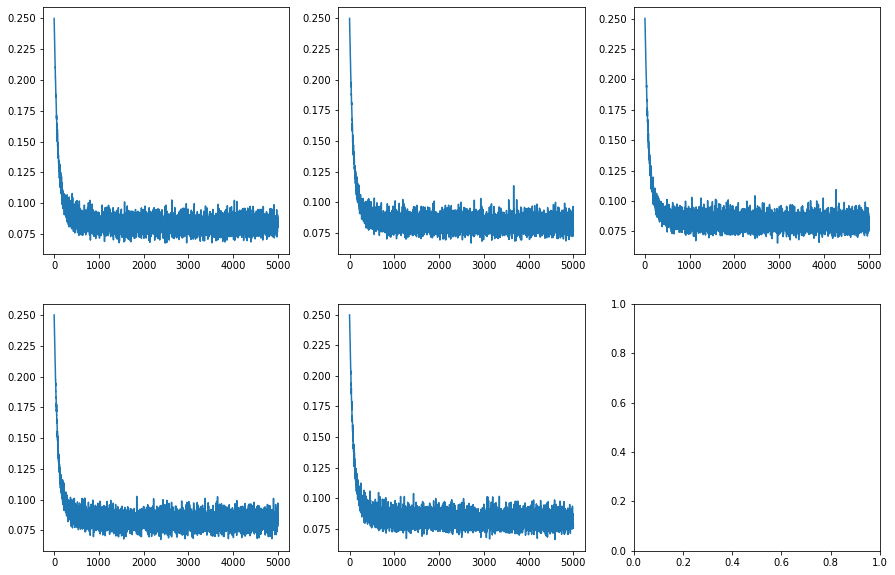

In [292]:
draw_loss(loss_list)

La taille de la dimension cachée répresente la quantité d'informations qui caractérise la représentation que le RBM va tenter d'extraire de l'image. C'est, en somme, la complexité maximale de l'abstraction qui pourra généré pendant l'apprentissage, ou bien l'espace de recherche pour déterminer les carcatéristiques des images d'entrainement.

certains des poids de ces valeurs pourront ne pas être très élevés, surtout si la dimension est importante.

Dans notre cas, on voit que les valeurs de la loss sont quasiement identiques, c'est sans doute car les paramètres suivants sont déja bien choisi, on va donc prendre 2000 pour la suite.

## Grid Search sur les paramètres d'entrainement

Effectuons maintenant une recherche par grille rapide avec les valeurs des paramètres qui semblait donner des résultats pertients.   

epochs : 50, 100
taille du batch : 20, 32
taux d'apprentissage : 1e-1, 1e-2
dimensions du vecteur caché : 

In [293]:
loss_list=[]
img_list=[]

epochs_values = [50, 100]
batch_size_value = [20,32]
lr_values = [1e-1, 1e-2]
h_dim_values = [1000,2000]

for epochs in epochs_values:
    for batch_size in batch_size_value:
        for lr in lr_values:
            for h_dim in h_dim_values:
                
                loss, model = train_RBM(train_set, batch_size, epochs, h_dim, lr)
                _, img_transformée = get_inference(model, test_set)
                img_list.append(img_transformée)
                loss_list.append(loss)

Training RBM : 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


Training finished at epoch 50 with a loss of : 0.0826861783862114


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.63it/s]


Training finished at epoch 50 with a loss of : 0.08277293294668198


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.65it/s]


Training finished at epoch 50 with a loss of : 0.08248989284038544


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.75it/s]


Training finished at epoch 50 with a loss of : 0.08248886466026306


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


Training finished at epoch 50 with a loss of : 0.0832352563738823


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.30it/s]


Training finished at epoch 50 with a loss of : 0.0825081318616867


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


Training finished at epoch 50 with a loss of : 0.08305956423282623


Training RBM : 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.35it/s]


Training finished at epoch 50 with a loss of : 0.08284474909305573


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]


Training finished at epoch 100 with a loss of : 0.08266319334506989


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.70it/s]


Training finished at epoch 100 with a loss of : 0.08266550302505493


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.71it/s]


Training finished at epoch 100 with a loss of : 0.08232119679450989


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.78it/s]


Training finished at epoch 100 with a loss of : 0.08230020850896835


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.40it/s]


Training finished at epoch 100 with a loss of : 0.08270050585269928


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Training finished at epoch 100 with a loss of : 0.08243780583143234


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s]


Training finished at epoch 100 with a loss of : 0.08222021907567978


Training RBM : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.20it/s]

Training finished at epoch 100 with a loss of : 0.08220349252223969


Le meilleur modèle obtenu avec la technique que l'on vient d'employer est celui qui a la loss la plus faible, c'est le 16ème modèle et il a les paramètres suivants :  

epochs = 100  
batch_size = 32  
learning rate = 1e-2  
hidden dim = 2000  